### Мотивация
Определение положения беспилотников с помощью микрофонов. Микрофоны записывают звук, над звуком произоводится wavelet анализ, результаты отправляются в нейросеть, которая определяет наличие беспилотника.

### Описание задачи

1. Разбить аудио на промежутки 2-5 сек
2. Посчитать среднее по промежутку, вычесть из промежутка посчитанное среднее. Это нужно для исключения шумов ветра 
3. Произвести wavelet анализ промежутков, определить удобный базис и необходимую частоту дискретизации, отметить на wavelet-графе спектры беспилотников. Эти wavelet-графы отправятся в нейросеть.

Примерные времена пролета беспилотников:

- 18 сек
- 50 сек
- 90 cек
- 120 сек
- 160 сек

Будем анализировать интервал времени 18 - 20 сек

In [16]:
START = 18
END = 20

Вспомогательные функции

In [70]:
# Inspiration
# https://www.scicoding.com/introduction-to-wavelet-transform-using-python/
# https://paos.colorado.edu/research/wavelets/bams_79_01_0061.pdf

import numpy as np
import matplotlib.pyplot as plt
import pywt
import wavio
from numpy.fft import rfft, rfftfreq

def load_data():
    """Выгрузка аудио из файла."""
    w = wavio.read("data/LmicX-14-04-33.wav")
    # print(f'{len(w.data) = }')
    # print(f'{w.rate = }')
    # print(f'{w.sampwidth = }')
    F = w.rate
    w.data = w.data.ravel().astype(np.int64)
    return F, w.data
def wavelet(signal, st, en, F, title="Wavelet", wavelet='cmor', save=True):
    """Wavelet-анализ и построение графиков."""
    x = signal[int(st*F) : int(en*F)]
    t = np.linspace(st, en, len(x))
    widths = np.geomspace(1, 1024, num=100)
    coefficients, frequencies = pywt.cwt(x, widths, sampling_period=1.0/F, wavelet=wavelet)

    fig, axs = plt.subplots(2, 1, figsize=(6, 6))
    pcm = axs[0].pcolormesh(t, frequencies, np.abs(coefficients))
    axs[0].set_yscale("log")
    axs[0].set_xlabel("Time, s")
    axs[0].set_ylabel("Frequency, Hz")
    axs[0].set_title(title)
    fig.colorbar(pcm, ax=axs[0])

    yf = rfft(x)
    xf = rfftfreq(len(x), 1.0/F)
    axs[1].semilogx(xf, np.abs(yf))
    axs[1].set_xlabel("Frequency (Hz)")
    axs[1].set_title("FFT")

    # axs[2].plot(t, x)
    # axs[2].set_xlabel("Time, s")
    # axs[2].set_title("Signal")
    plt.tight_layout()
    if save:
        plt.savefig('img/' + title)
    plt.show()
    return x
def filter_mean(signal, st, en, F, batch_size = 2, squares=False):
    """Фильтрация сигнала с помощью подсчёта среднего."""
    x = signal[int(st*F) : int(en*F)]

    batches = [x[:batch_size*F]]
    last_batch = 2
    while st + last_batch < en:
        batches.append(x[last_batch*F : (last_batch+batch_size)*F])
        last_batch += batch_size

    denoised_signal = []
    for i in range(len(batches)):
        if squares:
            mean_val = np.sqrt(np.sum(batches[i]**2))/len(batches[i])
        else:
            mean_val = np.mean(batches[i])
        denoised_signal.extend(batches[i] - mean_val)
    
    return denoised_signal

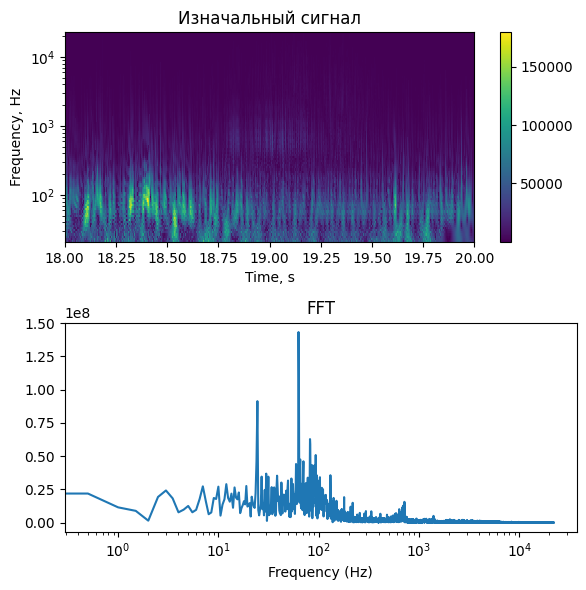

In [61]:
F, signal = load_data()
wavelet(signal, START, END, F, "Изначальный сигнал")

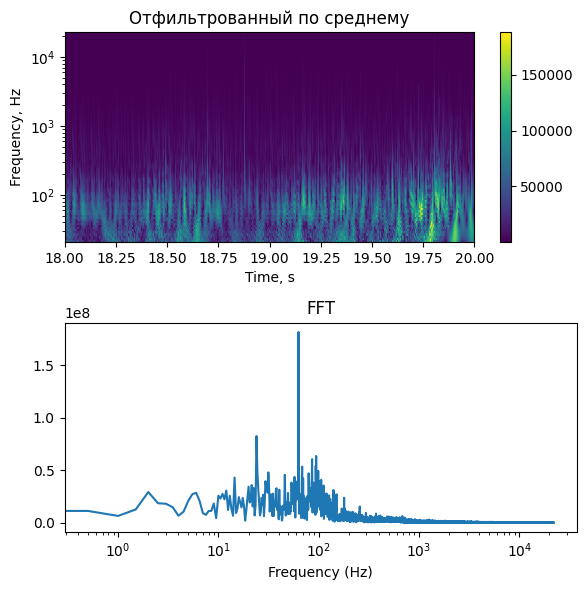

In [62]:
filtered_mean = filter_mean(signal, 5, 25, F)
wavelet(filtered_mean, START, END, F, "Отфильтрованный по среднему")

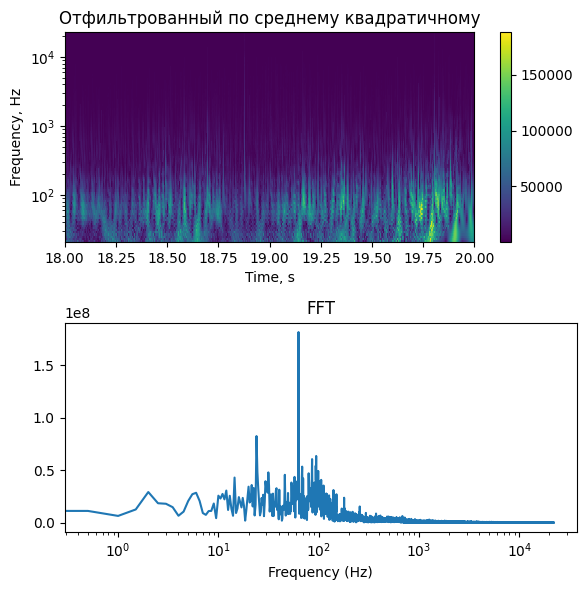

In [63]:
filtered_mean = filter_mean(signal, 5, 25, F, squares=True)
wavelet(filtered_mean, START, END, F, "Отфильтрованный по среднему квадратичному")

Видно, что звук коптера не различим!

## Попробуем отфильтровать сигнал с помощью КИХ ФВЧ
### Создание фильтра

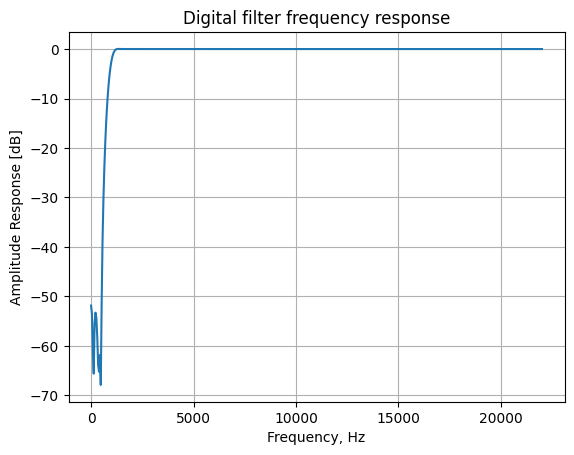

In [71]:
import scipy.signal
F, data = load_data()
b = scipy.signal.firwin(201, cutoff=F*0.02, fs=F, pass_zero='highpass')
w, h = scipy.signal.freqz(b, fs=F)

plt.title('Digital filter frequency response')
plt.plot(w, 20*np.log10(np.abs(h)))
plt.title('Digital filter frequency response')
plt.ylabel('Amplitude Response [dB]')
plt.xlabel('Frequency, Hz')
plt.grid()
plt.show()

### Применение фильтра

c:\dev\drons\.venv\Lib\site-packages\pywt\_cwt.py:121: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


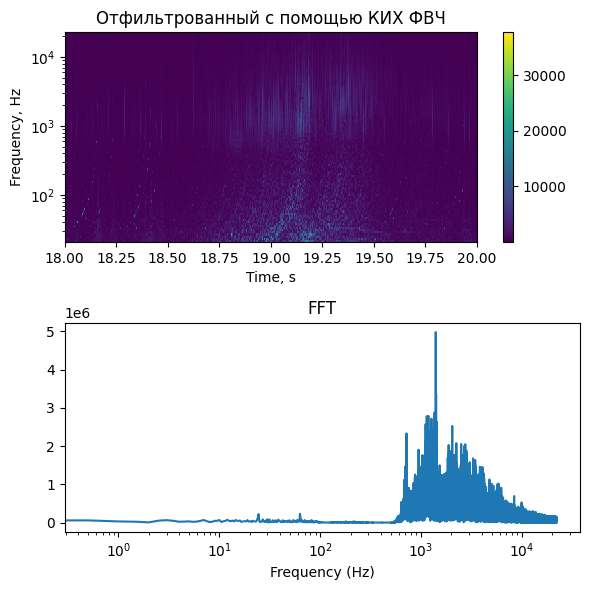

In [75]:
filtered = scipy.signal.lfilter(b, [1.0], signal)
sig = wavelet(filtered, START, END, F, "Отфильтрованный с помощью КИХ ФВЧ")

Рассмотрим промежуток времени 50 - 53 сек

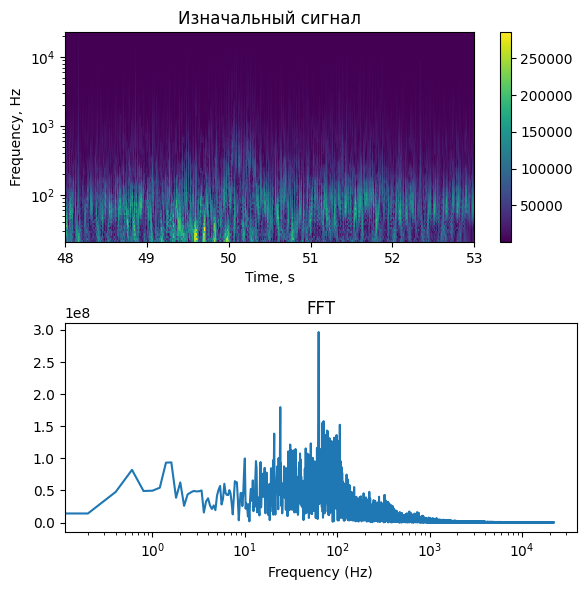

In [66]:
wavelet(signal, 48, 53, F, "Изначальный сигнал", save=False)

(-0.5, 1162.5, 591.5, -0.5)

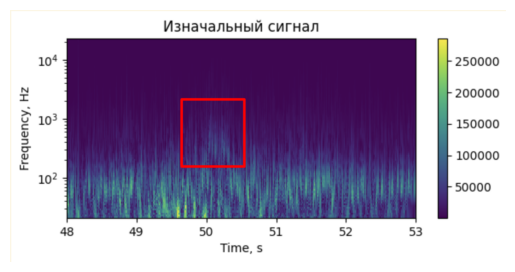

In [88]:
plt.imshow(Image.open('48_53_init.png'))
plt.axis('off')

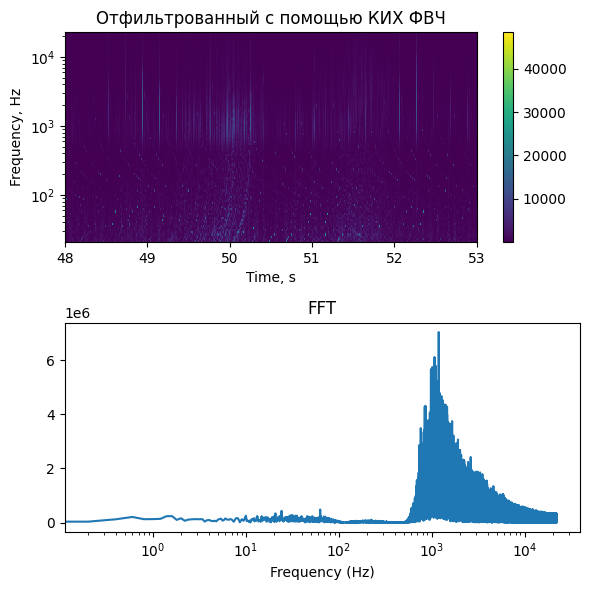

In [67]:
wavelet(filtered, 48, 53, F, "Отфильтрованный с помощью КИХ ФВЧ", save=False)

(-0.5, 1164.5, 576.5, -0.5)

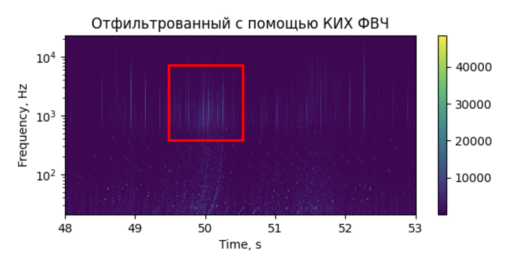

In [89]:
plt.imshow(Image.open('48_53_filtered.png'))
plt.axis('off')

# Сравнение всех графиков

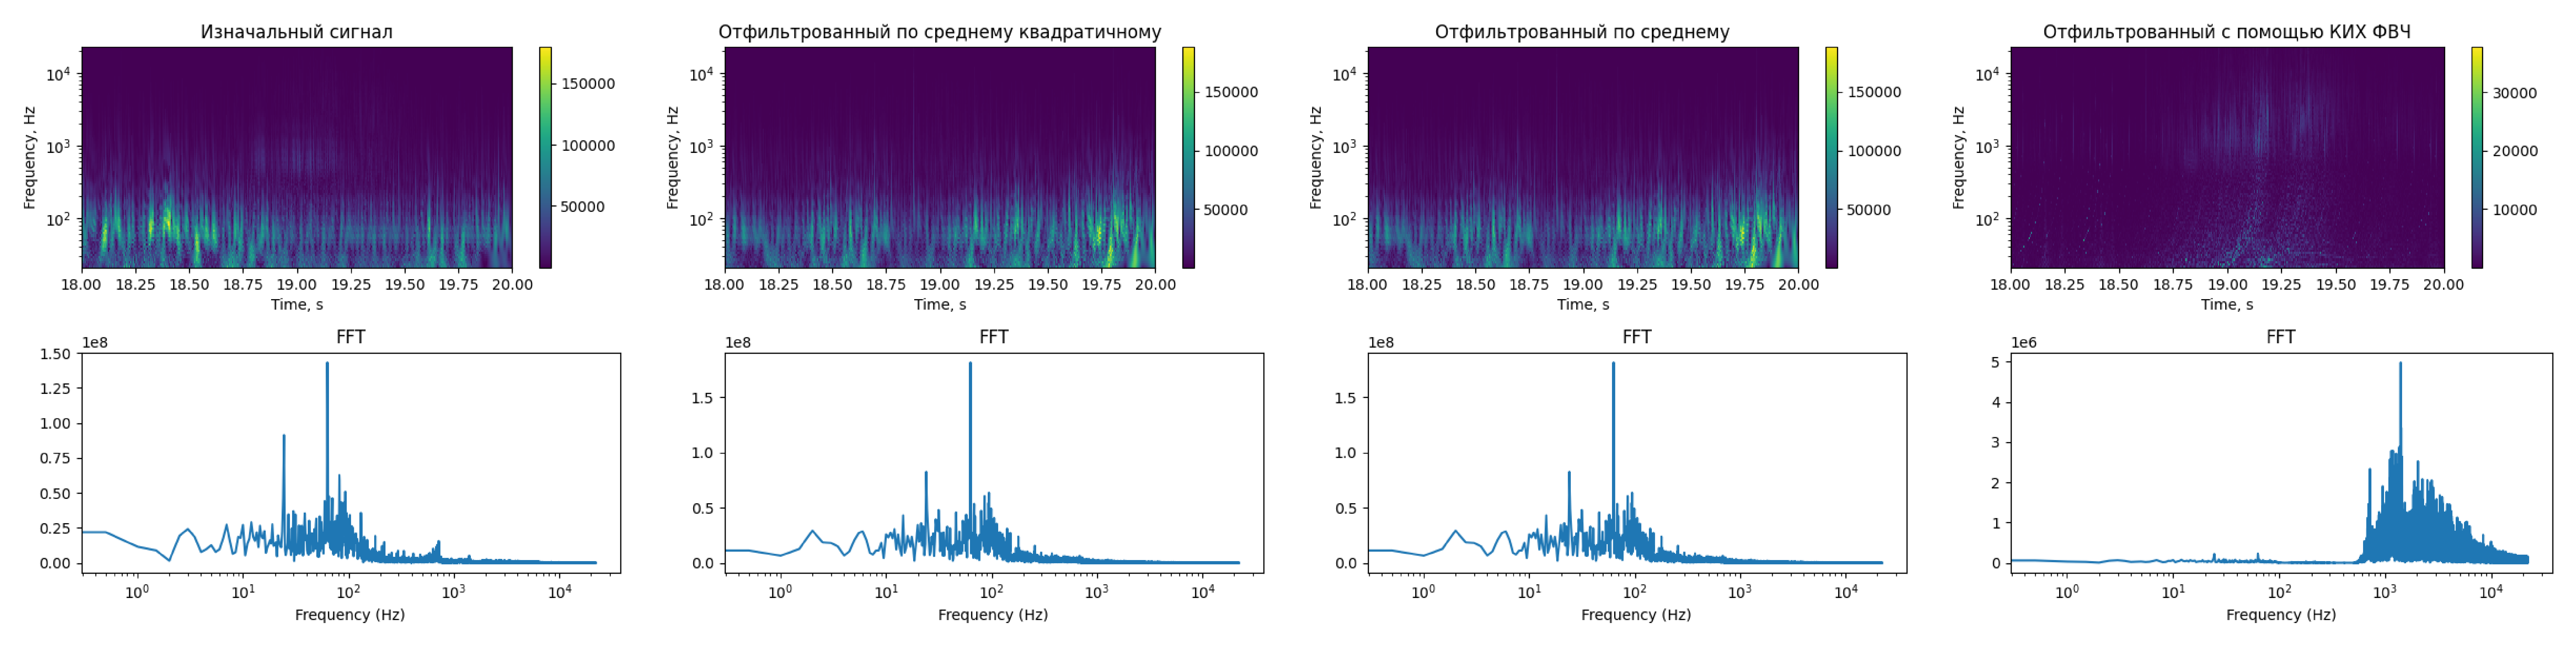

In [78]:
from PIL import Image
from os import listdir
from os.path import isfile, join

PATH = './img/'
def imshow(img_files):
    imgs = [Image.open(img_file) for img_file in img_files]
    n = len(imgs)
    plt.figure(figsize=(8*n, 15), dpi=300)
    if n > 1:
        for i, img in enumerate(imgs):
            plt.subplot(1, n, 1+i)
            plt.imshow(img)
            plt.axis('off')
    else:
        plt.imshow(imgs[0])
        plt.axis('off')
    plt.tight_layout()

imshow(list(PATH + f for f in listdir(PATH) if isfile(join(PATH, f))))

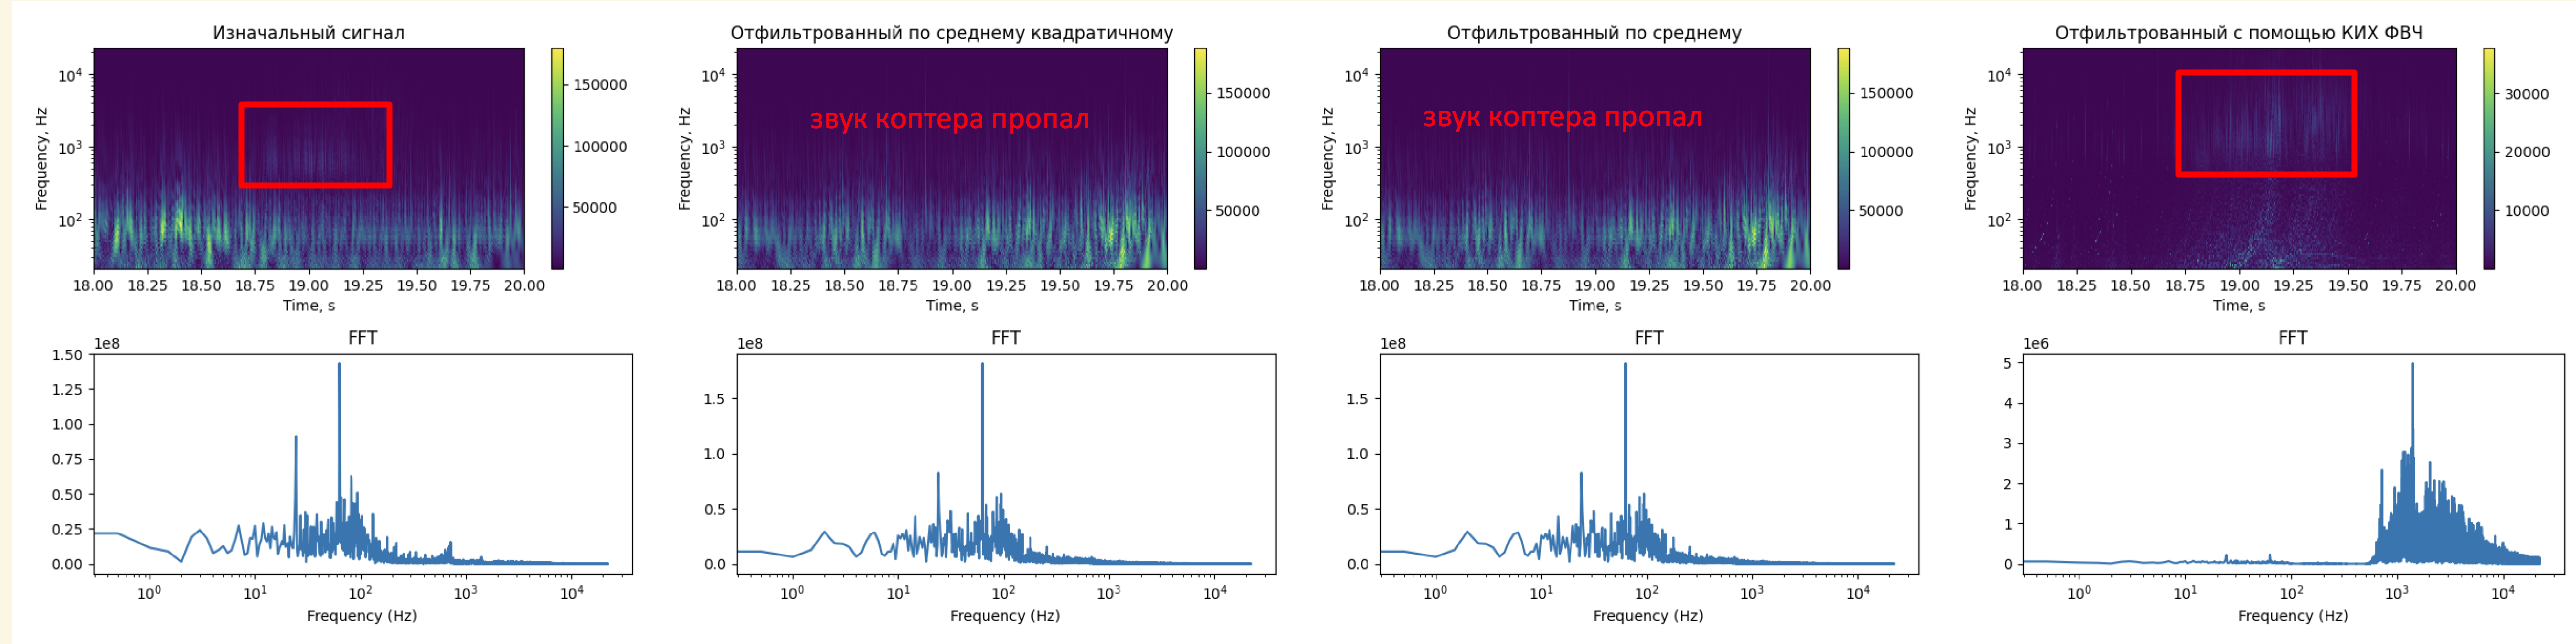

In [81]:
Image.open('18_20_all.png')